In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def show_image(img:torch.Tensor, label:str=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.imshow((np.transpose(npimg, (1, 2, 0))*255).astype('uint8'))
    if label is not None:
        plt.title(classes[label])
    plt.show()

In [4]:
class CFG:
    # dataset
    batch_size = 4
    
    # noise
    B_0 = 1e-4
    B_T = 2e-2
    T = 1000
    schedule_type = 'cosine'

In [5]:
import torch.utils
from torch.utils.data import DataLoader


class CIFAR10_Dataset():
    def __init__(self, split='train', transform=None):
        self.split = split
        self.transform = transform if transform else transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.load_set()
        

    def load_set(self):
        transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.set = torchvision.datasets.CIFAR10(root='./data', train = (self.split=='train'),
                                        download=True, transform=transform)
     
    def show_image(self, idx):
        img = self[idx]
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
    
    def __getitem__(self, idx:int) -> torch.Tensor:
        """
        Returns a Tensor of shape (3 x 32 x 32)
        """
        return self.set[idx]
        
    def __len__(self) -> int:
        return len(self.set)
    
    def __str__(self) -> str:
        return f"CIFAR dataset of size {len(self)}"
    def __repr__(self) -> str:
        return str(self)

batch_size = CFG.batch_size
train = CIFAR10_Dataset()
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)

Files already downloaded and verified


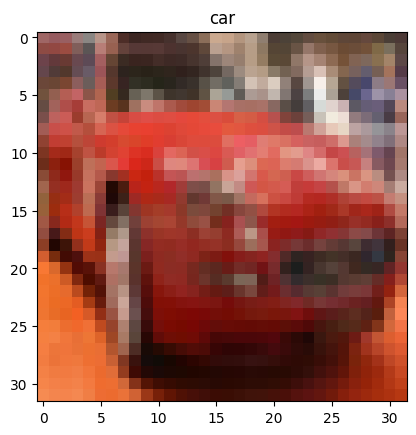

In [6]:
image, label = train[5]
show_image(image, label)

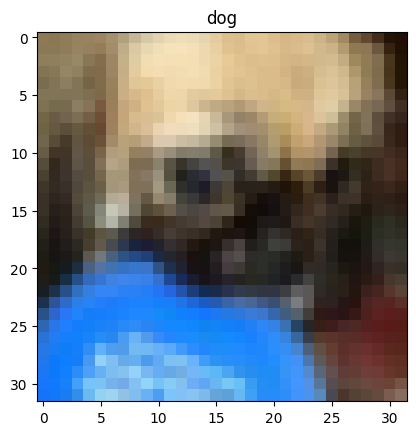

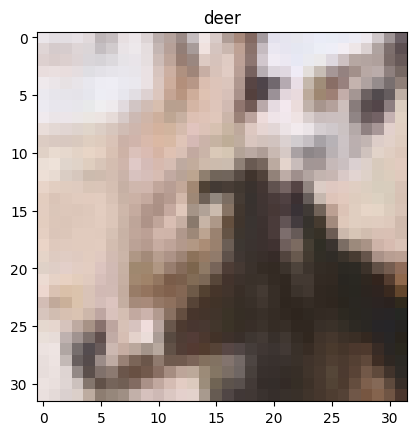

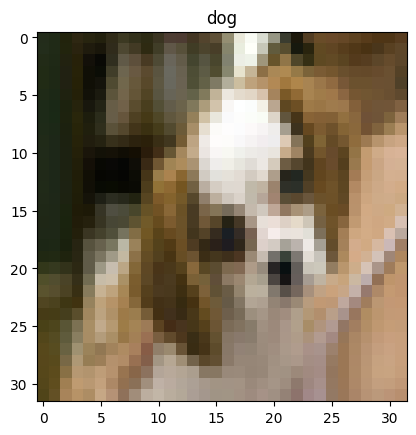

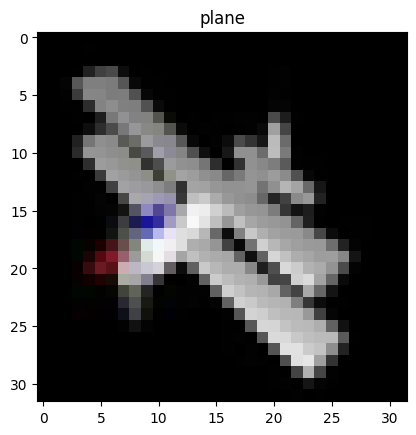

In [7]:
images, labels = next(iter(train_loader))
for image, label in zip(images, labels):
    show_image(image, label)

In [8]:
def add_noise(img:torch.Tensor, B_t):
    noise = torch.randn_like(img)
    x_t =  torch.sqrt(1 - B_t) * img + torch.sqrt(B_t) * noise
    return x_t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


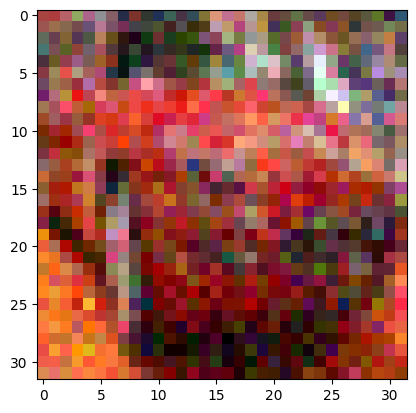

In [9]:
image, label = train[5]
# print(image)

B_t = torch.tensor(2e-2)
noise_image = add_noise(image, B_t)
noise_image = add_noise(noise_image, B_t)
show_image(noise_image)

In [10]:
class NoiseSchedule():
    def __init__(self, T:int, schedule_type:str, B_0:float, B_T:float):
        self.T = T
        self.schedule_type = schedule_type
        self.B_0 = B_0
        self.B_T = B_T
        self.t = 0
        if self.schedule_type == 'linear':
            self.schedule = self.linear_schedule()
        elif self.schedule_type == 'cosine':
            self.schedule = self.cosine_schedule()
        elif self.schedule_type == 'cosine2':
            self.schedule = self.cosine_schedule2()
        

    def linear_schedule(self) -> callable:
        return lambda t: torch.tensor(self.B_0 + (self.B_T - self.B_0) * t / self.T)
    def cosine_schedule(self):
        return lambda t: torch.tensor(self.B_0 + 0.5 * (self.B_T - self.B_0) * (1 - np.cos(np.pi * (t + 0.5) / self.T)))

    def cosine_schedule2(self):
        s=0.008
        return lambda t: torch.tensor(np.cos(((t/self.T) + s)/(1+s) * np.pi/2)**2)
    
    
    def __getitem__(self, t:int) -> float:
        if t >= self.T:
            raise IndexError(f"t must be less than {self.T}")
        return self.schedule(t)
    
    def __next__(self):
        self.t += 1
        return self.schedule(self.t)
    def __iter__(self):
        return self
    
    def plot_schedule(self):
        x = range(0, self.T)
        y = [self.schedule(t) for t in x]
        plt.plot(x, y)
        plt.show()
    

tensor(0.0001, dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)


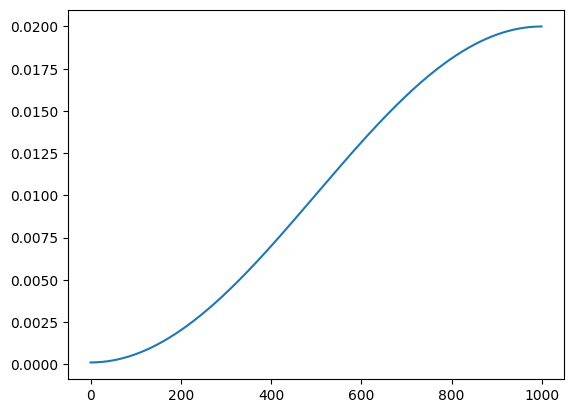

In [11]:
Schedule = NoiseSchedule(CFG.T, CFG.schedule_type, CFG.B_0, CFG.B_T)
Schedule = NoiseSchedule(CFG.T, 'linear', CFG.B_0, CFG.B_T)
Schedule = NoiseSchedule(CFG.T, 'cosine', CFG.B_0, CFG.B_T)
print(Schedule[0])

var = next(Schedule)
print(var)

Schedule.plot_schedule()

In [18]:
class NoiseAdder():
    def __init__(self, noise_schedule:NoiseSchedule = None):            
        self.Schedule = noise_schedule if noise_schedule else NoiseSchedule(CFG.T, CFG.schedule_type, CFG.B_0, CFG.B_T)
    
    def add_noise(self, img:torch.Tensor, B_t):
        noise = torch.randn_like(img)
        x_t =  torch.sqrt(1 - B_t) * img + torch.sqrt(B_t) * noise
        return x_t
    
    def image_at_time_step(self, img:torch.Tensor, t):
        if t>=self.Schedule.T:
            raise(ValueError(f"The value should be lower than {self.Schedule.T}"))
        alpha_t_barre = torch.prod(torch.tensor([(1 - self.Schedule.schedule(s)) for s in range(t)]))
        noise = torch.randn_like(img)
        return torch.sqrt(alpha_t_barre) * img + torch.sqrt(1 - alpha_t_barre) * noise

    def image_at_time_step_cosine_v2(self, img:torch.Tensor, t):
        if t>=self.Schedule.T:
            raise(ValueError(f"The value should be lower than {self.Schedule.T}"))
        s=0.008
        # alpha_t_barre = torch.prod(torch.tensor([(1 - self.Schedule.schedule(s)) for s in range(t)]))
        f = lambda x: torch.tensor(np.cos(((x/self.Schedule.T) + s)/(1+s) * np.pi/2)**2)
        alpha_t_barre = f(t)/f(0)
        noise = torch.randn_like(img)
        return torch.sqrt(alpha_t_barre) * img + torch.sqrt(1 - alpha_t_barre) * noise

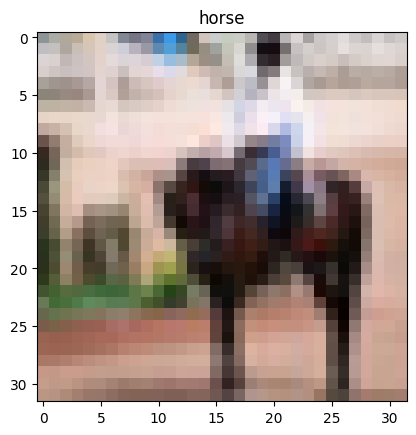

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


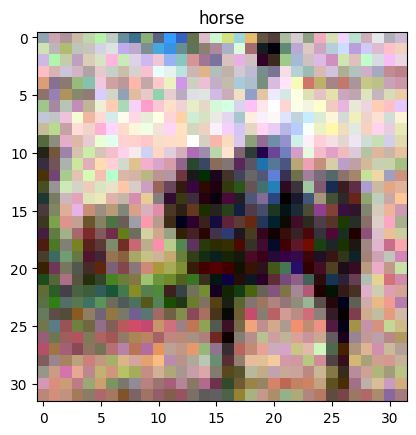

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


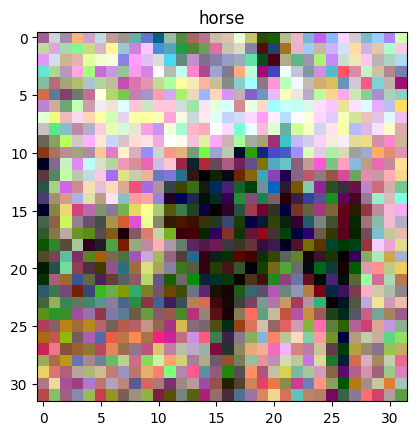

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


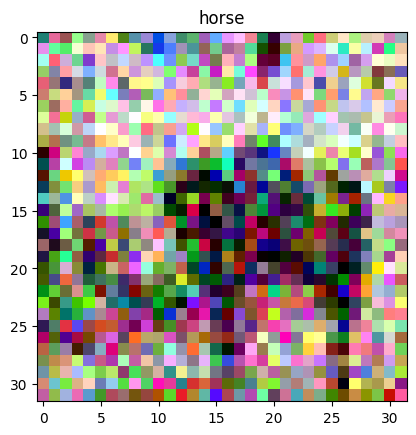

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


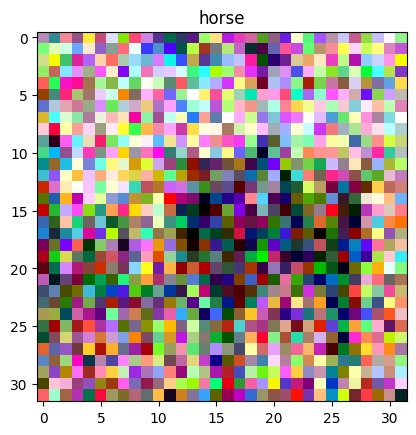

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


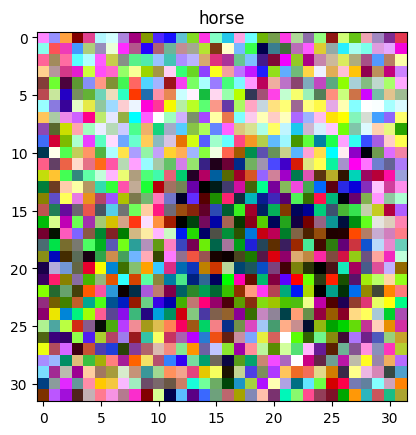

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


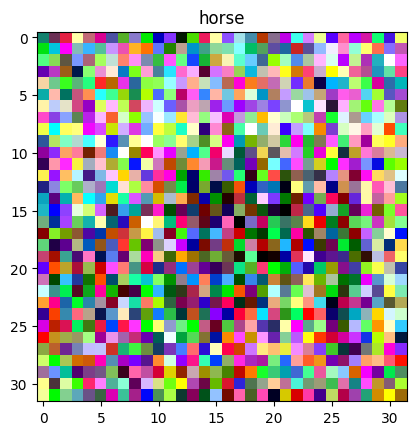

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


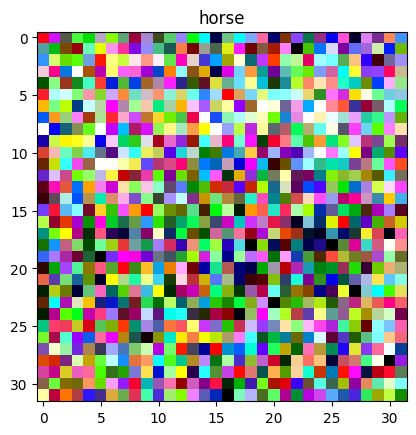

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


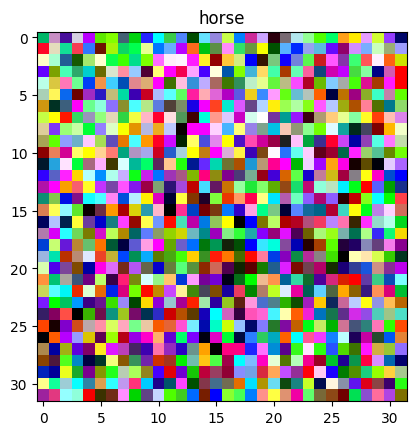

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


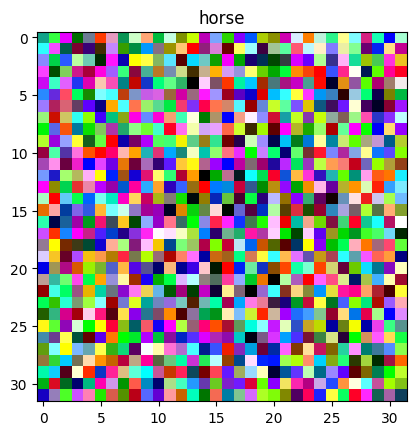

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


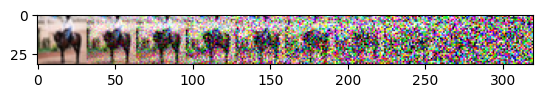

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


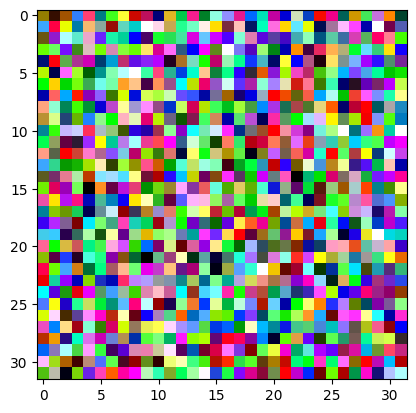

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


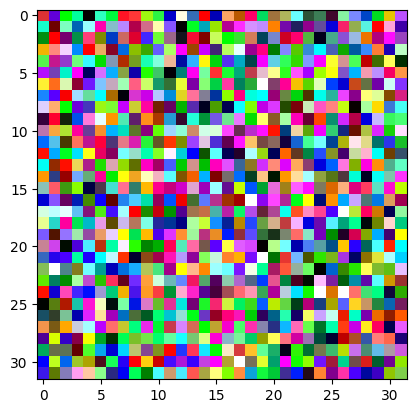

In [19]:
# Initialize noise schedule and adder
noise_schedule = NoiseSchedule(CFG.T, CFG.schedule_type, CFG.B_0, CFG.B_T)
noise_adder = NoiseAdder(noise_schedule)

# Example input image
img, label = train[11]
full_img = torch.tensor([])

# Visualize the noise addition process
for t in range(0, CFG.T, 100):
    noisy_img = noise_adder.image_at_time_step_cosine_v2(img, t)
    full_img = torch.cat((full_img, noisy_img), 2)
    show_image(noisy_img, label)
show_image(full_img)

# Visualize the final noisy image
final_noisy_img = noise_adder.image_at_time_step_cosine_v2(img, CFG.T - 1)
show_image(final_noisy_img)

# Verify that the final image is completely noisy
final_noise = torch.randn_like(img)
show_image(final_noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


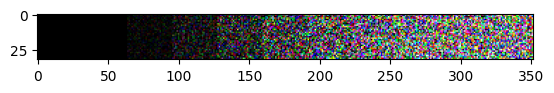

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


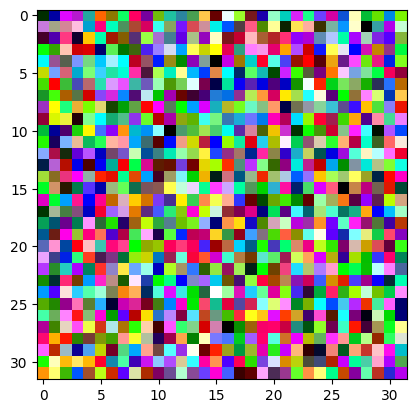

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


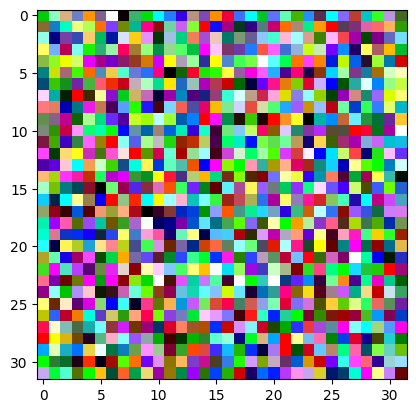

In [14]:
# Initialize noise schedule and adder
noise_schedule = NoiseSchedule(CFG.T, CFG.schedule_type, CFG.B_0, CFG.B_T)
noise_adder = NoiseAdder(noise_schedule)

# Example input image
img = torch.ones((3,32,32)) * -1
full_img = img.clone()

# Visualize the noise addition process
for t in range(0, CFG.T, 100):
    noisy_img = noise_adder.image_at_time_step(img, t)
    full_img = torch.cat((full_img, noisy_img), 2)
    # show_image(noisy_img)
show_image(full_img)

# Visualize the final noisy image
final_noisy_img = noise_adder.image_at_time_step(img, CFG.T - 1)
show_image(final_noisy_img)

# Verify that the final image is completely noisy
final_noise = torch.randn_like(img)
show_image(final_noise)

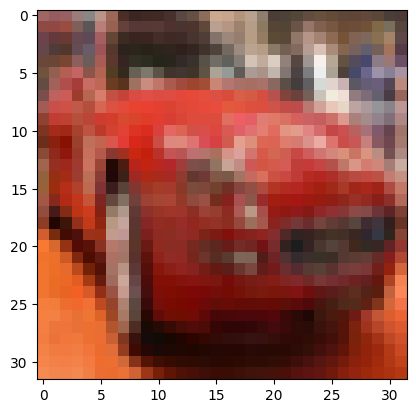

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


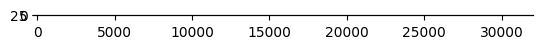

In [14]:
noise_adder = NoiseAdder()

image, label = train[5]
show_image(image)
noise_image = image.clone()
full_image = noise_image.clone()

for _ in range(noise_adder.Schedule.T):
    noise_image = noise_adder.add_noise(noise_image, next(noise_adder.Schedule))
    full_image = torch.cat((full_image, noise_image), 2)
show_image(full_image)

In [ ]:
noise_adder = NoiseAdder()

image, label = train[5]
show_image(image)

for i in range(noise_adder.Schedule.T):
    noise_image = noise_adder.image_at_time_step(image, i)
    show_image(noise_image)